<a href="https://colab.research.google.com/github/cjhauhan/Online-Retail-Dataset-Analysis/blob/main/Online_Retail_Anaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Firstly we will import the dataset Onlie Retail.xlsx

In [1]:
import pandas as pd
data = pd.read_excel('/content/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
data.shape

(541909, 8)

# **Data Cleaning & Assumptions**

1.1)  Handling missing values

In [3]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


The CustomerID contains 135080 missing values.

And Description contains 1454

In [7]:
# Dropping rows with missing CustomerID (if necessary)
data_cleaned = data.dropna(subset=['CustomerID'])

# Optionally, you can fill missing Description values with 'Unknown'
data_cleaned['Description'].fillna('Unknown', inplace=True)

<ipython-input-7-eab9add679b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Description'].fillna('Unknown', inplace=True)


**1.2) Removing duplicates**

In [ ]:
# Drop duplicate rows
data_cleaned = data_cleaned.drop_duplicates()

**Step 1.3: Handling Invalid or Negative Values**





In [ ]:
# Remove rows where Quantity or UnitPrice are negative
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]


# **2. Understanding Outliers**

**Step 2.1: Detect Outliers**

In [ ]:
# Using z-score to detect outliers in Quantity and UnitPrice
from scipy import stats
data_cleaned['Quantity_Zscore'] = stats.zscore(data_cleaned['Quantity'])
data_cleaned['UnitPrice_Zscore'] = stats.zscore(data_cleaned['UnitPrice'])

# Filtering out rows where z-score is too high or low
outlier_threshold = 3  # Common threshold for outliers
data_no_outliers = data_cleaned[(data_cleaned['Quantity_Zscore'].abs() < outlier_threshold) &
                                (data_cleaned['UnitPrice_Zscore'].abs() < outlier_threshold)]


**Step 2.2: Visualize Outliers**

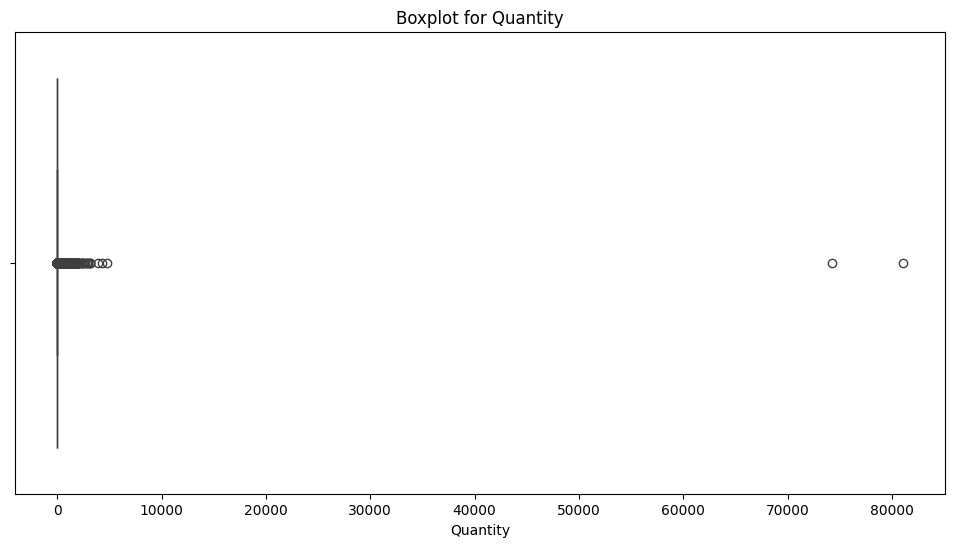

<Figure size 640x480 with 0 Axes>

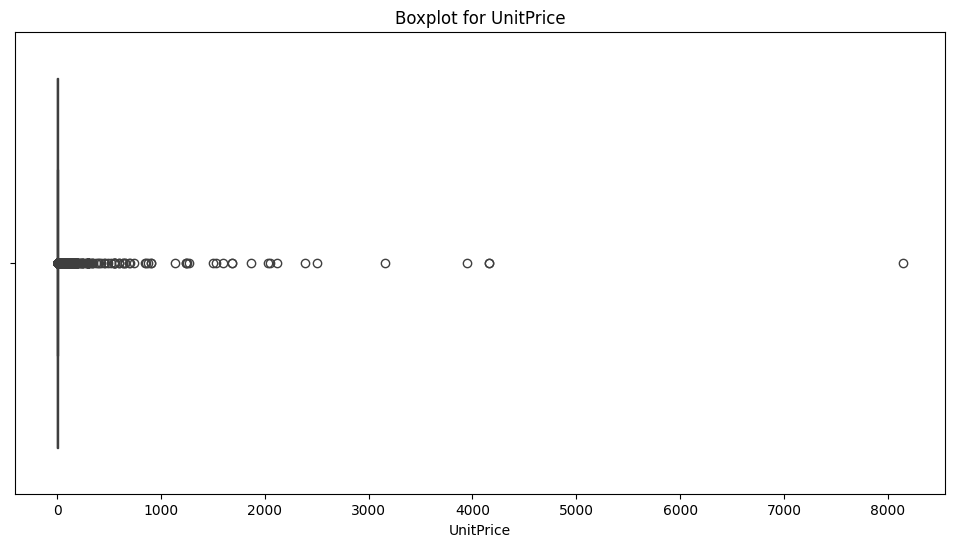

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for visualizing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_cleaned['Quantity'])
plt.title('Boxplot for Quantity')
plt.show()
plt.savefig('boxplot_quantity.png')

# Similarly for UnitPrice
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_cleaned['UnitPrice'])
plt.title('Boxplot for UnitPrice')
plt.show()
plt.savefig('boxplot_unitprice.png')


# **3. Data Analysis Process**

**Step 3.1: Create TotalSales Feature**

In [ ]:
# Creating a new TotalSales feature
data_cleaned['TotalSales'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']


 **Step 3.2: Extract Date Features**

 This code extracts features like year, month, day, and hour from InvoiceDate for temporal analysis.

In [ ]:
# Extracting date-based features
data_cleaned['InvoiceYear'] = pd.DatetimeIndex(data_cleaned['InvoiceDate']).year
data_cleaned['InvoiceMonth'] = pd.DatetimeIndex(data_cleaned['InvoiceDate']).month
data_cleaned['InvoiceDay'] = pd.DatetimeIndex(data_cleaned['InvoiceDate']).day
data_cleaned['InvoiceHour'] = pd.DatetimeIndex(data_cleaned['InvoiceDate']).hour


In [ ]:
data_cleaned['InvoiceYear']

,InvoiceYear
0,2010
1,2010
2,2010
3,2010
4,2010
...,...
541904,2011
541905,2011
541906,2011
541907,2011


**Step 3.3: RFM Analysis**

This groups transactions by CustomerID and calculates Recency (days since last purchase), Frequency (number of purchases), and Monetary (total spending).

In [ ]:
# Recency, Frequency, Monetary (RFM) Analysis
rfm_table = data_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data_cleaned['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalSales': 'sum'    # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSales': 'Monetary'})

rfm_table.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


# **4. Insights and Visualization**

Step 4.1: Sales Trends Over Time

This plots total sales over time, allowing you to identify trends like seasonal sales peaks or dips.

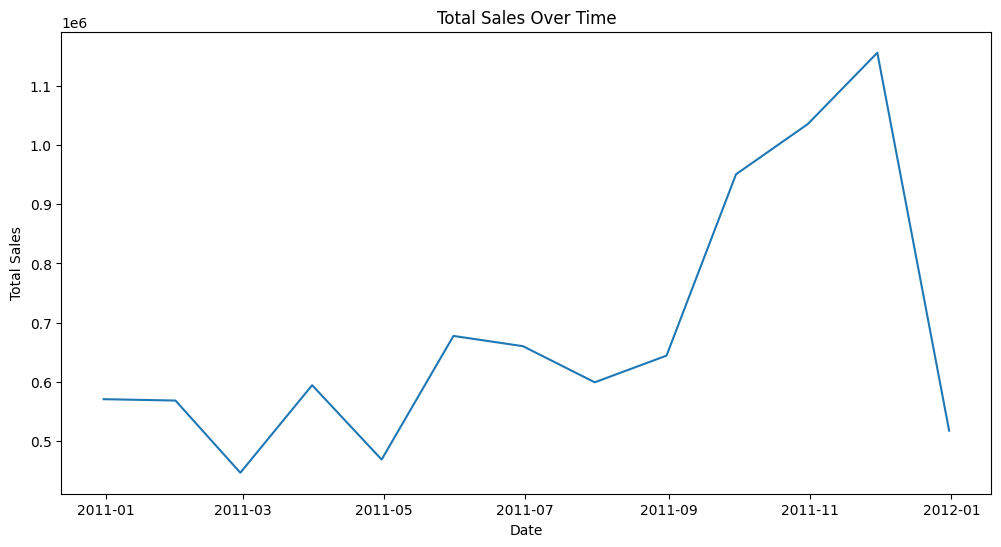

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting sales over time
sales_over_time = data_cleaned.groupby('InvoiceDate').agg({'TotalSales': 'sum'}).resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_over_time.index, sales_over_time['TotalSales'])
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()
plt.savefig('sales_over_time.png')


**Step 4.2: Top Products by Sales**

This visualizes the top 10 products based on total revenue.

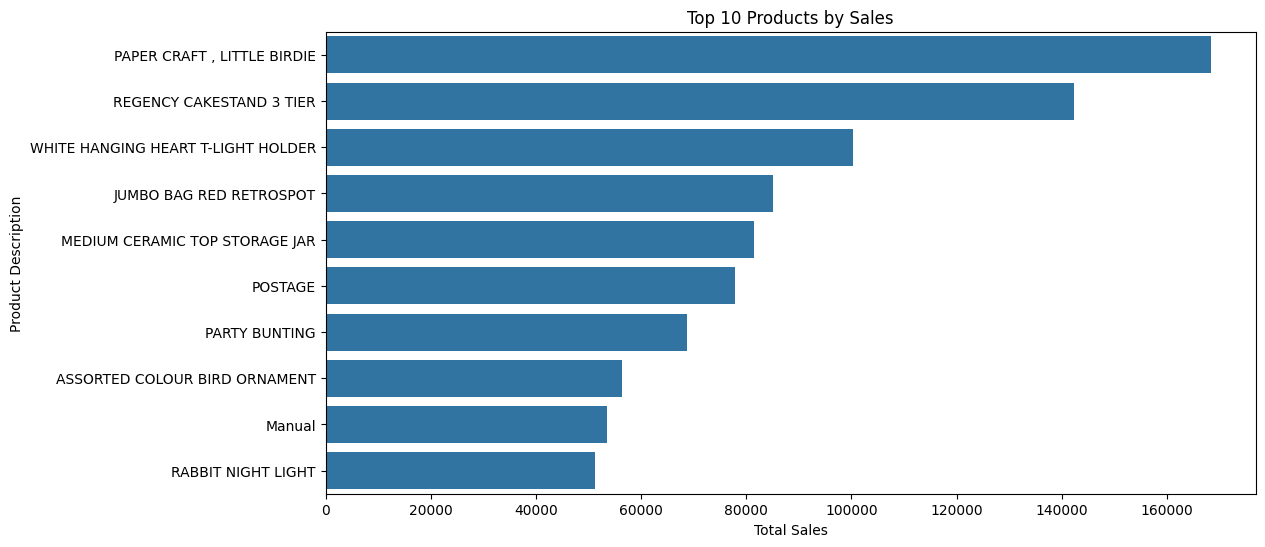

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finding top products by total sales
top_products = data_cleaned.groupby('Description')['TotalSales'].sum().sort_values(ascending=False).head(10)

# Plotting top 10 products
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Description')
plt.show()
plt.savefig('top_products.png')


**Step 4.3: Sales by Country**

This plot compares sales across different countries.

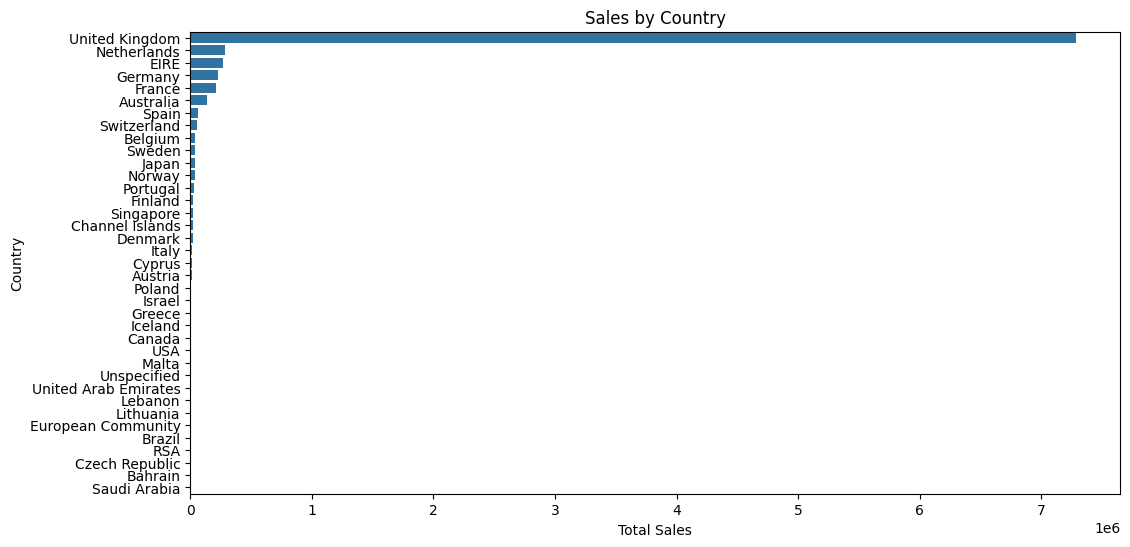

<Figure size 640x480 with 0 Axes>

In [ ]:
# Total sales by country
sales_by_country = data_cleaned.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_country.values, y=sales_by_country.index)
plt.title('Sales by Country')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.show()
plt.savefig('sales_by_country.png')


# **5. Recommendations**

**Step 5.1**: Use the insights from top-selling products, sales trends, and customer segmentation to provide actionable recommendations.
For example:
Inventory Management: Keep top-selling products in stock to avoid missing sales.

Target Marketing: Focus marketing efforts on high-value customer segments using RFM scores.

Geographical Focus: Consider expanding operations in countries with high sales potential or where growth is visible.

In [ ]:
data_cleaned


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Quantity_Zscore,UnitPrice_Zscore,TotalSales,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,-0.039446,-0.025893,15.30,2010,12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,-0.039446,0.011873,20.34,2010,12,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,-0.028365,-0.016901,22.00,2010,12,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,-0.039446,0.011873,20.34,2010,12,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,-0.039446,0.011873,20.34,2010,12,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,-0.006204,-0.102326,10.20,2011,12,9,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,-0.039446,-0.046125,12.60,2011,12,9,12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,-0.050527,0.046043,16.60,2011,12,9,12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,-0.050527,0.046043,16.60,2011,12,9,12
